# Measure the Difference between Preprint-Published similarity and Published Articles

In [1]:
from datetime import timedelta
import random
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
import requests
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegressionCV
from scipy.stats import linregress
import tqdm

from mizani.breaks import date_breaks
from mizani.formatters import timedelta_format

# Gather Preprint-Published Pairs

## bioRxiv Document Embeddings

In [2]:
url = "https://api.biorxiv.org/pub/2000-01-01/3000-01-01/"

In [3]:
already_downloaded = Path("output/biorxiv_published_dates.tsv").exists()
if not already_downloaded:
    collection = []
    page_size = 100
    total = 44397
    for i in tqdm.tqdm(range(0, total, page_size), total=total/page_size):
        collection += requests.get(url + str(i)).json()["collection"]
    published_dates = pd.DataFrame(collection)
    published_dates.to_csv("output/biorxiv_published_dates.tsv", sep="\t", index=False)
else:
    published_dates = pd.read_csv("output/biorxiv_published_dates.tsv", sep="\t")

published_dates.head()

,biorxiv_doi,published_doi,preprint_title,preprint_category,preprint_date,published_date,published_citation_count
0,10.1101/001081,10.1093/bioinformatics/btu121,PyRAD: assembly of de novo RADseq loci for phy...,Bioinformatics,2013-12-03,2014-03-05,184
1,10.1101/001297,10.1371/journal.pone.0085203,Aerodynamic characteristics of a feathered din...,Biophysics,2013-12-10,2014-01-15,11
2,10.1101/000422,10.3389/fgene.2014.00013,On the optimal trimming of high-throughput mRN...,Bioinformatics,2013-11-14,2014-01-31,44
3,10.1101/001396,10.1162/NECO_a_00568,Parametric inference in the large data limit u...,Biophysics,2013-12-13,2014-03-10,4
4,10.1101/002980,10.1016/j.bpj.2014.01.012,Genetic drift suppresses bacterial conjugation...,Biophysics,2014-02-24,2014-02-18,10


In [4]:
biorxiv_journal_df = (
    pd.read_csv(
        "../journal_tracker/output/mapped_published_doi.tsv", 
        sep="\t"
    )
    .groupby("doi")
    .agg({
        "document":"first",
        "category":"first",
        "journal":"first",
        "doi":"count",
        "published_doi":"first",  
        "pmcid":"first", 
        "pmcoa":"first",
    })
    .rename(index=str, columns={"doi":"version_count"})
    .reset_index()
)
biorxiv_journal_df.head()

,doi,document,category,journal,version_count,published_doi,pmcid,pmcoa
0,10.1101/000026,000026_v1.xml,genetics,PLoS Genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True
1,10.1101/000042,000042_v1.xml,genomics,Nature Reviews Genetics,3,10.1038/nrg3723,PMC4151119,False
2,10.1101/000067,000067_v1.xml,genomics,Nature,1,10.1038/nature12904,PMC4285441,True
3,10.1101/000091,000091_v1.xml,synthetic biology,NaN,1,NaN,NaN,False
4,10.1101/000109,000109_v1.xml,evolutionary biology,PLoS Genetics,1,10.1371/journal.pgen.1004410,PMC4072524,True


In [5]:
biorxiv_embed_df = (
    pd.read_csv(
        Path("../word_vector_experiment/output/") /
        "word2vec_output/" /
        "biorxiv_all_articles_300.tsv.xz",
        sep="\t"
    )   
)
biorxiv_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,-0.185549,-0.028703,-0.148555,-0.133172,0.353365,-0.114964,-0.028663,-0.215159,0.551382,...,-0.286513,0.082141,-0.197929,-0.163326,-0.867377,-0.383934,0.684275,0.673811,0.332528,-0.252338
1,775270_v1.xml,-0.532040,-0.065809,-0.313654,-0.117575,0.372866,-0.318956,-0.368010,0.325850,0.808698,...,-0.199805,-0.083095,0.184185,-0.157145,-0.895367,-0.611417,0.224433,0.857584,-0.442240,-0.229249
2,242404_v1.xml,-0.511104,-0.203790,-0.171574,0.244052,0.235567,-0.269997,-0.222966,-0.247174,0.385497,...,-0.351890,-0.155088,-0.222041,-0.258185,-0.866121,-0.568663,0.553375,0.890001,0.025051,-0.347382
3,872994_v1.xml,-0.595936,-0.147790,-0.277296,0.522433,0.574653,-0.046103,-0.586993,-0.312505,0.382142,...,0.074240,0.042758,0.174565,0.155595,-0.557984,-0.445246,0.386596,0.512007,-0.510197,-0.295844
4,080853_v2.xml,-0.076522,0.039275,-0.928818,0.226103,0.035823,-0.075580,-0.189354,0.243075,0.240977,...,0.524121,0.560223,0.246179,0.242929,-0.810809,-0.118951,0.052647,0.184235,-0.154029,0.469902


## PMC Article Embeddings

In [6]:
pmc_articles_df = (
    pd.read_csv(
        Path("../../pmc/exploratory_data_analysis/") /
        "output/pubmed_central_journal_paper_map.tsv.xz", 
        sep="\t"
    )
    .query("article_type=='research-article'")
)
pmc_articles_df.head()

,journal,article_type,doi,pmcid
0,Environ_Health,research-article,10.1186/1476-069X-5-22,PMC1552054
1,Environ_Health,research-article,10.1186/1476-069X-4-12,PMC1226148
3,Environ_Health,research-article,10.1186/s12940-017-0316-3,PMC5635510
4,Environ_Health,research-article,10.1186/1476-069X-10-46,PMC3125232
5,Environ_Health,research-article,10.1186/1476-069X-11-91,PMC3533997


In [7]:
pmc_embed_df = (
    pd.read_csv(
        list(
            Path("../../pmc/word_vector_experiment/output/")
            .glob("*300.tsv.xz")
        )[0],
        sep="\t"
    )
)
pmc_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,-0.245809,0.431974,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,0.037062,0.530896,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,-0.159638,0.866190,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,-0.156994,0.695519,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,-0.007002,0.586774,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


# Gather Golden bioRxiv Set

In [8]:
matched_preprint_published_pairs = (
    biorxiv_journal_df
    .query("pmcoa==True")
    .sort_values("document")
    .merge(
        published_dates
        [["biorxiv_doi", "preprint_date", "published_date"]]
        .rename(index=str, columns={"biorxiv_doi":"doi"}),
        on="doi"
    )
    .assign(
        preprint_date = lambda x: pd.to_datetime(x.preprint_date.tolist()),
        published_date = lambda x: pd.to_datetime(
            x.published_date.apply(lambda y: y[0:y.index(":")] if ":" in y else y)
        )
    )
    .assign(
        time_to_published = lambda x: x.published_date - x.preprint_date
    )
)
matched_preprint_published_pairs.head()

,doi,document,category,journal,version_count,published_doi,pmcid,pmcoa,preprint_date,published_date,time_to_published
0,10.1101/000026,000026_v1.xml,genetics,PLoS Genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,2013-11-07,2014-08-07,273 days
1,10.1101/000067,000067_v1.xml,genomics,Nature,1,10.1038/nature12904,PMC4285441,True,2013-11-07,2014-02-27,112 days
2,10.1101/000109,000109_v1.xml,evolutionary biology,PLoS Genetics,1,10.1371/journal.pgen.1004410,PMC4072524,True,2013-11-07,2014-06-26,231 days
3,10.1101/000141,000141_v1.xml,cancer biology,PLoS Computational Biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,2013-11-07,2014-01-16,70 days
4,10.1101/000158,000158_v1.xml,bioinformatics,BMC Genomics,1,10.1186/1471-2164-15-398,PMC4041996,True,2013-11-11,2014-05-24,194 days


# Calculate the Document Distances

In [9]:
biorxiv_documents = (
    biorxiv_embed_df
    .query(f"document in {matched_preprint_published_pairs.document.tolist()}")
    .set_index("document")
    .loc[matched_preprint_published_pairs.document.tolist()]
)
biorxiv_documents.head()

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
000026_v1.xml,-0.354588,-0.039688,-0.264044,0.061171,0.445177,-0.094280,-0.207811,-0.268134,0.514608,-0.172241,...,0.077113,0.009006,-0.128140,0.107098,-0.896259,-0.591504,0.451696,1.010107,0.155138,-0.141590
000067_v1.xml,-0.223833,0.104426,-0.187421,-0.097920,0.118555,-0.162342,-0.065943,0.034351,0.316731,-0.843266,...,0.110930,0.144949,0.003651,-0.035206,-0.887362,-0.582829,0.407179,0.400775,0.030982,0.238798
000109_v1.xml,-0.359770,-0.034423,-0.211397,0.142895,0.257640,0.214825,0.053788,-0.111075,0.252922,-0.389549,...,0.131452,0.034245,0.119621,-0.075230,-0.786596,-0.557854,0.163636,0.867464,0.000889,0.181491
000141_v1.xml,-0.489331,0.029247,-0.766819,0.126920,0.228847,-0.231903,-0.362439,0.288067,0.539021,-0.497395,...,0.390265,0.303159,0.268525,0.173529,-0.685519,-0.613437,0.188164,0.561036,0.024270,-0.074251
000158_v1.xml,-0.184118,0.065338,-0.151212,0.281209,0.096208,-0.315909,-0.313868,-0.143971,0.471824,-0.286004,...,-0.040810,-0.056940,-0.258915,-0.034394,-0.636722,-0.097607,0.717791,0.791196,0.074980,-0.112038


In [10]:
pmc_documents = (
    pmc_embed_df
    .query(f"document in {matched_preprint_published_pairs.pmcid.tolist()}")
    .set_index("document")
    .loc[matched_preprint_published_pairs.pmcid.tolist()]
)
pmc_documents.head()

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC4125079,-0.393989,-0.105368,-0.188610,-0.000827,0.466840,-0.110281,-0.267658,-0.254811,0.694553,-0.167737,...,-0.023798,-0.067774,-0.138133,0.131621,-0.915233,-0.702165,0.510522,1.050556,0.189830,-0.159675
PMC4285441,-0.202318,0.063607,-0.169501,0.182838,0.092618,-0.251825,-0.051630,0.127893,0.315889,-0.867483,...,0.087915,-0.072969,0.011872,-0.095772,-0.804453,-0.574449,0.269103,0.368860,-0.241790,0.293816
PMC4072524,-0.407997,-0.057107,-0.162155,0.056570,0.317807,0.204410,0.060930,-0.085344,0.351246,-0.421611,...,0.123592,0.041612,0.064592,-0.032610,-0.820932,-0.535412,0.285843,0.914426,0.066386,0.163916
PMC3894166,-0.503416,0.009370,-0.754106,0.152181,0.285587,-0.186768,-0.380495,0.292699,0.522160,-0.507823,...,0.414183,0.246784,0.284164,0.261274,-0.678757,-0.567737,0.203805,0.600919,0.069438,-0.128604
PMC4041996,-0.227117,0.044183,-0.159964,0.232780,0.168320,-0.291611,-0.318501,-0.151195,0.552665,-0.320804,...,-0.078128,-0.075647,-0.250499,0.007998,-0.670497,-0.147619,0.799633,0.784076,0.170619,-0.095224


In [11]:
published_date_distances = (
    matched_preprint_published_pairs
    .assign(
        doc_distances = np.diag(cdist(biorxiv_documents.values, pmc_documents.values, 'euclidean'))
    )
    .query("doc_distances.notnull()")
)
print(published_date_distances.shape)
published_date_distances.head()

(17260, 12)


,doi,document,category,journal,version_count,published_doi,pmcid,pmcoa,preprint_date,published_date,time_to_published,doc_distances
0,10.1101/000026,000026_v1.xml,genetics,PLoS Genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,2013-11-07,2014-08-07,273 days,1.640911
1,10.1101/000067,000067_v1.xml,genomics,Nature,1,10.1038/nature12904,PMC4285441,True,2013-11-07,2014-02-27,112 days,1.683717
2,10.1101/000109,000109_v1.xml,evolutionary biology,PLoS Genetics,1,10.1371/journal.pgen.1004410,PMC4072524,True,2013-11-07,2014-06-26,231 days,1.244658
3,10.1101/000141,000141_v1.xml,cancer biology,PLoS Computational Biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,2013-11-07,2014-01-16,70 days,0.972641
4,10.1101/000158,000158_v1.xml,bioinformatics,BMC Genomics,1,10.1186/1471-2164-15-398,PMC4041996,True,2013-11-11,2014-05-24,194 days,1.077589


# Construct Scatter Plot of Date vs Version Count

In [12]:
# Get smoothed linear regression line
x = (
    published_date_distances
    .time_to_published
    .apply(lambda x: x/timedelta(days=1))
    .tolist()
)

y = (
    published_date_distances
    .version_count
    .values
    .tolist()
)

xseq = (
    np.linspace(np.min(x), np.max(x), 80)
)
results = linregress(x, y)
print(results)

LinregressResult(slope=0.00187748877734208, intercept=1.089221630718766, rvalue=0.3080681416150141, pvalue=0.0, stderr=4.413490299643107e-05)


In [13]:
# Get smoothed linear regression line
x = (
     published_date_distances
    .version_count
    .values
    .tolist()
)

y = (
    published_date_distances
    .time_to_published
    .apply(lambda x: x/timedelta(days=1))
    .tolist()
)

xseq_2 = (
    np.linspace(np.min(x), np.max(x), 80)
)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=50.549425926521245, intercept=131.6275451731479, rvalue=0.3080681416150141, pvalue=0.0, stderr=1.188286202674757)


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/scales/scale.py:611: PlotnineWarning: You have changed the transform of a specialised scale. The result may not be what you expect.
Original transform: pd_timedelta
New transform: pd_timedel
  PlotnineWarning
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/article_distance_vs_publication_time_dots.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/danich1/anaconda3/envs/annorxiver/lib/py

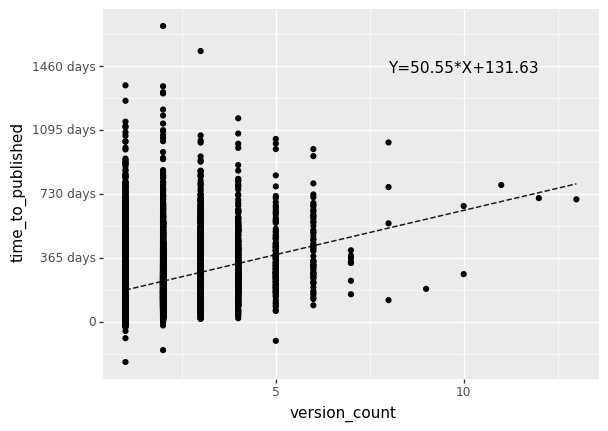

<ggplot: (8773424513270)>


In [14]:
g = (
    p9.ggplot(
        published_date_distances, 
        p9.aes(y="time_to_published", x="version_count")
    )
    + p9.geom_point()
    + p9.geom_line(
        stat="smooth",method='lm', linetype='dashed', 
        se=False, alpha=0.9, size=0.6
    )
    + p9.scale_y_timedelta(labels=timedelta_format('d'))
    + p9.annotate(
        'text', x=10, y=timedelta(days=1450), 
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}"
    )
)
g.save("output/article_distance_vs_publication_time_dots.png", dpi=500)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/scales/scale.py:611: PlotnineWarning: You have changed the transform of a specialised scale. The result may not be what you expect.
Original transform: pd_timedelta
New transform: pd_timedel
  PlotnineWarning
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/article_distance_vs_publication_time.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/danich1/anaconda3/envs/annorxiver/lib/python3

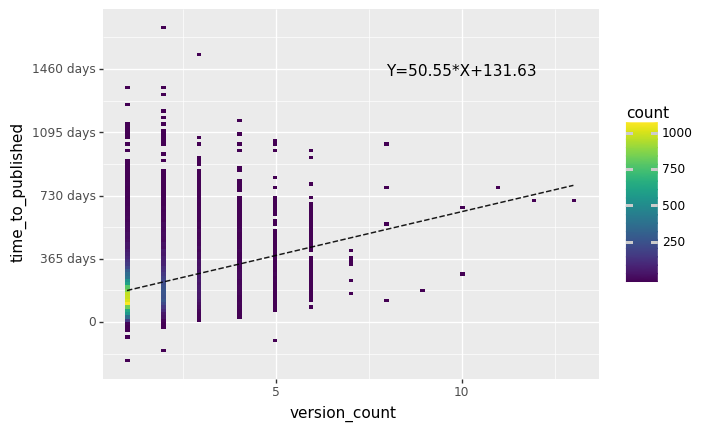

<ggplot: (-9223363263429755802)>


In [15]:
g = (
    p9.ggplot(
        published_date_distances, 
        p9.aes(x="version_count", y="time_to_published")
    )
    + p9.geom_bin2d(bins=100)
    + p9.geom_line(
        stat="smooth",method='lm', linetype='dashed', 
        se=False, alpha=0.9, size=0.6
    )
    + p9.scale_y_timedelta(labels=timedelta_format('d'))
    + p9.annotate(
        'text', x=10, y=timedelta(days=1450), 
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}"
    )
)
g.save("output/article_distance_vs_publication_time.svg", dpi=500)
g.save("output/article_distance_vs_publication_time.png", dpi=500)
print(g)

# Construct Scatter Plot of Date vs Document Distances

In [16]:
# Get smoothed linear regression line
x = (
    published_date_distances
    .time_to_published
    .apply(lambda x: x/timedelta(days=1))
    .tolist()
)

y = (
    published_date_distances
    .doc_distances
    .values
    .tolist()
)

xseq = (
    np.linspace(np.min(x), np.max(x), 80)
)
results = linregress(x, y)
print(results)

LinregressResult(slope=0.0005220919142466701, intercept=1.285490509016312, rvalue=0.09201129564518193, pvalue=9.011070656834333e-34, stderr=4.300949833591336e-05)


In [17]:
# Get smoothed linear regression line
x = (
     published_date_distances
    .doc_distances
    .values
    .tolist()
)

y = (
    published_date_distances
    .time_to_published
    .apply(lambda x: x/timedelta(days=1))
    .tolist()
)

xseq_2 = (
    np.linspace(np.min(x), np.max(x), 80)
)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=16.215685965029426, intercept=183.67128432831436, rvalue=0.09201129564518193, pvalue=9.011070656834333e-34, stderr=1.3358347438399827)


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/scales/scale.py:611: PlotnineWarning: You have changed the transform of a specialised scale. The result may not be what you expect.
Original transform: pd_timedelta
New transform: pd_timedel
  PlotnineWarning
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/article_distance_vs_publication_time_dots.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/danich1/anaconda3/envs/annorxiver/lib/py

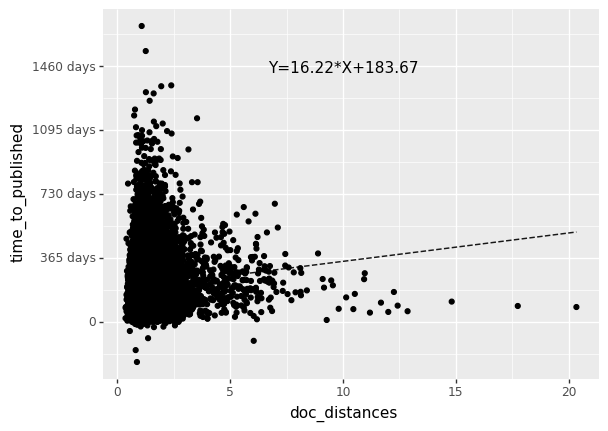

<ggplot: (8773425059069)>


In [18]:
g = (
    p9.ggplot(
        published_date_distances, 
        p9.aes(y="time_to_published", x="doc_distances")
    )
    + p9.geom_point()
    + p9.geom_line(
        stat="smooth",method='lm', linetype='dashed', 
        se=False, alpha=0.9, size=0.6
    )
    + p9.scale_y_timedelta(labels=timedelta_format('d'))
    + p9.annotate(
        'text', x=10, y=timedelta(days=1450), 
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}"
    )
)
g.save("output/article_distance_vs_publication_time_dots.png", dpi=500)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/scales/scale.py:611: PlotnineWarning: You have changed the transform of a specialised scale. The result may not be what you expect.
Original transform: pd_timedelta
New transform: pd_timedel
  PlotnineWarning
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/article_distance_vs_publication_time.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/danich1/anaconda3/envs/annorxiver/lib/python3

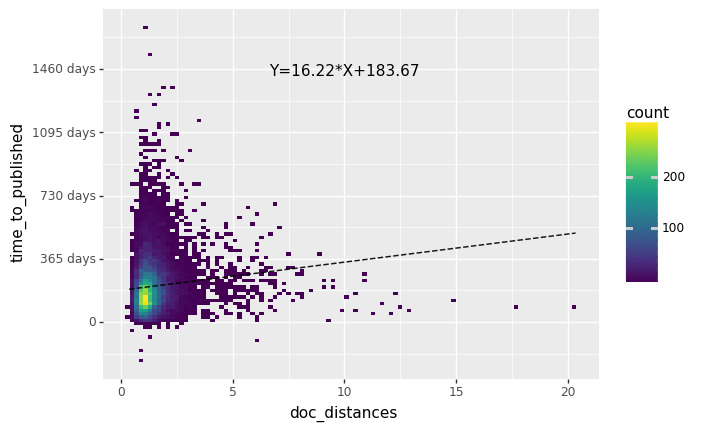

<ggplot: (8773424678790)>


In [19]:
g = (
    p9.ggplot(
        published_date_distances, 
        p9.aes(x="doc_distances", y="time_to_published")
    )
    + p9.geom_bin2d(bins=100)
    + p9.geom_line(
        stat="smooth",method='lm', linetype='dashed', 
        se=False, alpha=0.9, size=0.6
    )
    + p9.scale_y_timedelta(labels=timedelta_format('d'))
    + p9.annotate(
        'text', x=10, y=timedelta(days=1450), 
        label=f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}"
    )
)
g.save("output/article_distance_vs_publication_time.svg", dpi=500)
g.save("output/article_distance_vs_publication_time.png", dpi=500)
print(g)

# Contextualize Document Distances

The goal here is to understand what a unit of distance represents for two document embeddings. It is already established that low distances can indicate similar documents, but question remains how does a unit of distances relate to time taken to get published?

In [20]:
def random_combination(iterable, r, size=100, seed=100):
    "Random selection from itertools.combinations(iterable, r)"
    random.seed(seed)
    
    pool = tuple(iterable)
    n = len(pool)
    
    indices = [
        sorted(random.sample(range(n), r)) 
        for elem in range(size)
    ]
    
    for i in indices:
        yield (pool[i[0]], pool[i[1]])

def article_distances(iterable, embed_df, combination_size=2, sample_size=100, seed=100):
    article_pair_generator = (
        random_combination(
            iterable,
            combination_size,
            sample_size,
            seed
        )
    )

    paper_one, paper_two = zip(*article_pair_generator)
    temp_index = embed_df.set_index("document")

    return (
        np.diag(
            cdist(
                temp_index.loc[list(paper_one)].values, 
                temp_index.loc[list(paper_two)].values, 
                'euclidean'
            )
        )
    )

In [33]:
# Randomly sample two papers from the same journal 1000 times - plos one
plos_one_distances = (
    article_distances(
        biorxiv_journal_df
        .query("journal=='Genetics'")
        .document
        .tolist(),
        biorxiv_embed_df,
        2,
        1000
    )
)

print(
    f"Genetics Stats Mean: {np.mean(plos_one_distances):.3f}, "
    f"Std: {np.std(plos_one_distances):.3f}"
)

Genetics Stats Mean: 5.216, Std: 1.484


In [29]:
# Randomly sample two papers from the same field category 1000 times - bioinformatics
bioinformatic_distances = (
    article_distances(
        biorxiv_journal_df
        .query("category == 'bioinformatics'")
        .query(f"document in {biorxiv_embed_df.document.tolist()}")
        .document
        .tolist(),
        biorxiv_embed_df,
        2,
        1000
    )
)

print(
    f"Bioinformatics Stats Mean: {np.mean(bioinformatic_distances):.3f}, "
    f"Std: {np.std(bioinformatic_distances):.3f}"
)

Bioinformatics Stats Mean: 5.068, Std: 1.116


In [30]:
# Randomly sample two papers from the entire bioRxiv corpus 1000 times
biorxiv_distances = (
    article_distances(
        biorxiv_journal_df
        .query(f"document in {biorxiv_embed_df.document.tolist()}")
        .document
        .tolist(),
        biorxiv_embed_df,
        2,
        1000
    )
)

print(
    f"Biorxiv Stats Mean: {np.mean(biorxiv_distances):.3f}, "
    f"Std: {np.std(biorxiv_distances):.3f}"
)

Biorxiv Stats Mean: 6.212, Std: 1.308
